In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
import time
import json

import ase
from ase.io import read, write
import numpy as np
import chemiscope
from sklearn.decomposition import KernelPCA

from tqdm.notebook import tqdm

import rascal
from rascal.representations import SphericalInvariants
from rascal.models import Kernel

from tools.utils import fix_frames, train_test_split, filter_frames, get_config_type, draw_dimer_curve
from tools.radial_basis import draw_radial_basis

For this exercise we will use the [Silicon dataset](https://doi.org/10.1103/PhysRevX.8.041048) published with

```
Machine Learning a General-Purpose Interatomic Potential for Silicon
Albert P. Bartók, James Kermode, Noam Bernstein, and Gábor Csányi
Phys. Rev. X 8, 041048 – Published 14 December 2018
```

The branch of librascal is `master`, the tutorial is at `https://github.com/felixmusil/mlip_workshop2021.git`, and you can install chemiscope with `pip install chemiscope`.



In [2]:
import urllib.request

url = "https://github.com/libAtoms/silicon-testing-framework/raw/master/models/GAP/gp_iter6_sparse9k.xml.xyz"
# Download the file from `url`, save it in a temporary directory and get the
structures_fn, headers = urllib.request.urlretrieve(url)
structures_fn

'/tmp/tmprtf16ee1'

# Make a map with kernel pca projection

In [3]:
# load the structures without the isolated configuration
frames = fix_frames(read(structures_fn,'1:'))
global_species = [14]

## look at the details of the dataset

In [4]:
config_types = []
for frame in frames:
    config_types.append(frame.info['config_type'])


Radial distribution function of the silicon dataset

![](images/rdf.png)

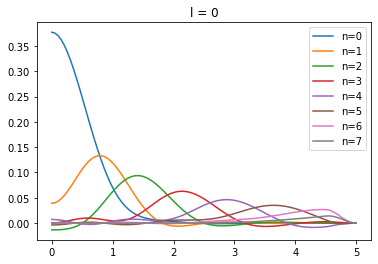

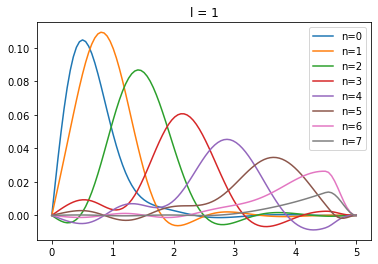

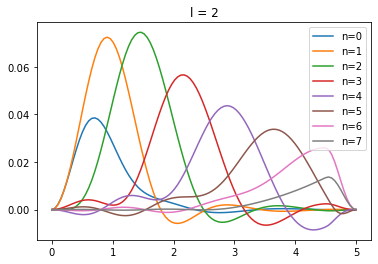

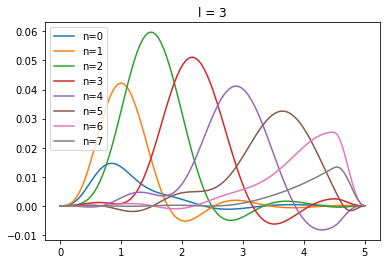

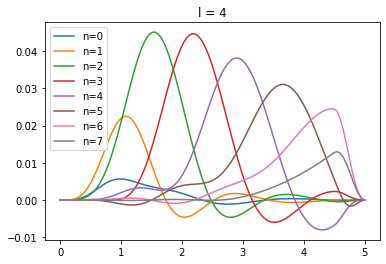

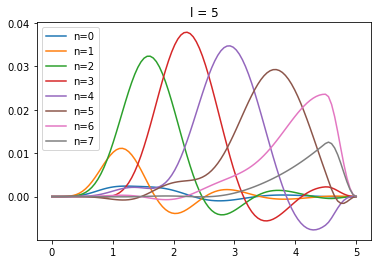

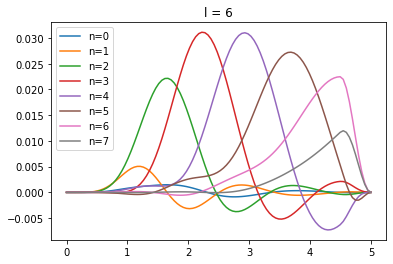

In [5]:
draw_radial_basis()

## Compute the representation, kernel and projection

In [6]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              optimization={"Spline":{"accuracy": 1e-5}},
              compute_gradients=False,
              )
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='Cosine', zeta=2, target_type='Structure', kernel_type='Full')

In [7]:
# Compute the representation of all the structures
feature_list = soap.transform(frames)

In [8]:
Kmat = kernel(feature_list)

In [ ]:
Kmat = np.load('kmat.npy')

In [9]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
X = kpca.fit_transform(Kmat)

## make an interactive map

In [10]:
phases = np.unique(config_types)
phases_map = {phase: ii for ii,phase in enumerate(phases)}

In [12]:

properties = {
    "PCA": X,
    "phase": [phases_map[phase] for phase in config_types],
}

chemiscope.show(frames=frames, properties=properties)

ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 1, "names": ["Si"], "x": [0…

In [13]:
print(phases_map)

{'111adatom': 0, 'amorph': 1, 'bc8': 2, 'bcc': 3, 'bt': 4, 'crack_110_1-10': 5, 'crack_111_1-10': 6, 'decohesion': 7, 'dia': 8, 'divacancy': 9, 'fcc': 10, 'hcp': 11, 'hex_diamond': 12, 'interstitial': 13, 'liq': 14, 'screw_disloc': 15, 'sh': 16, 'sp': 17, 'sp2': 18, 'st12': 19, 'surface_001': 20, 'surface_110': 21, 'surface_111': 22, 'surface_111_3x3_das': 23, 'surface_111_pandey': 24, 'vacancy': 25}
